In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 39.6 MB/s 
     |████████████████████████████████| 163 kB 58.2 MB/s 


In [3]:
import transformers
transformers.__version__

'4.23.0'

In [4]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [5]:
kr_data = pd.read_csv('./drive/MyDrive/newKR.csv')

jp_data = pd.read_csv('./drive/MyDrive/newJPppp.csv')

kr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39900 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [6]:
jp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39397 entries, 0 to 39396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39397 non-null  object
 1   label   39397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 615.7+ KB


v2열의 유니크한 값 : 38523
총 샘플의 수 : 38523


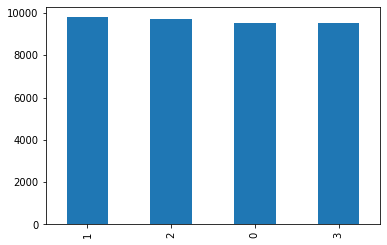

In [7]:
print('v2열의 유니크한 값 :',jp_data['tweet'].nunique())

jp_data.drop_duplicates(subset=['tweet'], inplace=True)

print('총 샘플의 수 :',len(jp_data))

jp_data['label'].value_counts().plot(kind='bar')

In [8]:
x_jpdata = jp_data['tweet']
y_jpdata = jp_data['label']

print('메일 본문의 개수: {}'.format(len(x_jpdata)))
print('레이블의 개수: {}'.format(len(y_jpdata)))

X_jptrain, X_jptest, y_jptrain, y_jptest = train_test_split(x_jpdata, y_jpdata, test_size=0.2, random_state=0, stratify=y_jpdata)

메일 본문의 개수: 38523
레이블의 개수: 38523


In [9]:
from transformers import T5Tokenizer, RobertaForMaskedLM

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [10]:
tokenizer = AutoTokenizer.from_pretrained("rinna/japanese-gpt2-small", bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Downloading:   0%|          | 0.00/282 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [11]:
import torch

In [12]:
max_seq_len = 256

In [13]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [14]:
train_X, train_y = convert_examples_to_features(X_jptrain, y_jptrain, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 30818/30818 [00:07<00:00, 4087.41it/s]


In [15]:
test_X, test_y = convert_examples_to_features(X_jptest, y_jptest, 
                                              max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 7705/7705 [00:02<00:00, 2704.03it/s]


In [16]:
# 최대 길이: 128
input_id = test_X[0]
label = test_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    2     9  6173  1362   635    26   154   774   626 11143    12 10073
   926  7909  3526    58  9835    10  4794   401    11  2081  3407 15680
 30986  3593    55  9835    17 25464 21674    40 15284  9835  4794   401
  4907   512 22035   128   315 10642   314   341 17666    55  7909  3526
   706   842  9328   748  1598  2334    17  5605  5094  2225   502    12
  2334    17  5605 23630   736    28     2 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000 32000
 32000 32000 32000 32000 32000 3200

In [17]:
model = TFGPT2Model.from_pretrained('rinna/japanese-gpt2-small', from_pt=True)

Downloading:   0%|          | 0.00/846 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['lm_head.weight', 'transformer.h.0.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.4.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [18]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [19]:
class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(0.45)
        self.classifier = tf.keras.layers.Dense(4,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [20]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [21]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py

In [24]:
local_device_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")

In [25]:
with strategy.scope():
  model = TFGPT2ForSequenceClassification("rinna/japanese-gpt2-small")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=1e-6)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  mc = ModelCheckpoint('GPT_modeljp', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weight_only=True, save_format="tf", options=local_device_option)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['lm_head.weight', 'transformer.h.0.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.4.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [26]:
history = model.fit(train_X, train_y, epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/30
386/386 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7748
Epoch 1: val_accuracy improved from -inf to 0.84766, saving model to GPT_modeljp


386/386 [==============================] - 269s 478ms/step - loss: 0.5929 - accuracy: 0.7748 - val_loss: 0.4058 - val_accuracy: 0.8477
Epoch 2/30
386/386 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8757
Epoch 2: val_accuracy improved from 0.84766 to 0.88352, saving model to GPT_modeljp


386/386 [==============================] - 126s 328ms/step - loss: 0.3400 - accuracy: 0.8757 - val_loss: 0.3112 - val_accuracy: 0.8835
Epoch 3/30
386/386 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9312
Epoch 3: val_accuracy improved from 0.88352 to 0.90964, saving model to GPT_modeljp


386/386 [==============================] - 127s 329ms/step - loss: 0.1911 - accuracy: 0.9312 - val_loss: 0.2702 - val_accuracy: 0.9096
Epoch 4/30
386/386 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9682
Epoch 4: val_accuracy improved from 0.90964 to 0.91596, saving model to GPT_modeljp


386/386 [==============================] - 128s 332ms/step - loss: 0.0924 - accuracy: 0.9682 - val_loss: 0.2800 - val_accuracy: 0.9160
Epoch 5/30
386/386 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9859
Epoch 5: val_accuracy did not improve from 0.91596
386/386 [==============================] - 56s 146ms/step - loss: 0.0427 - accuracy: 0.9859 - val_loss: 0.3354 - val_accuracy: 0.9156
Epoch 6/30
386/386 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9902
Epoch 6: val_accuracy improved from 0.91596 to 0.92408, saving model to GPT_modeljp


386/386 [==============================] - 126s 328ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.3405 - val_accuracy: 0.9241
Epoch 7/30
386/386 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9927
Epoch 7: val_accuracy did not improve from 0.92408
386/386 [==============================] - 57s 147ms/step - loss: 0.0200 - accuracy: 0.9927 - val_loss: 0.4029 - val_accuracy: 0.9130
Epoch 8/30
386/386 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9944
Epoch 8: val_accuracy improved from 0.92408 to 0.92537, saving model to GPT_modeljp


386/386 [==============================] - 126s 326ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.3639 - val_accuracy: 0.9254
Epoch 9/30
386/386 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9950
Epoch 9: val_accuracy did not improve from 0.92537
386/386 [==============================] - 57s 146ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.4077 - val_accuracy: 0.9130
Epoch 10/30
386/386 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9944
Epoch 10: val_accuracy did not improve from 0.92537
386/386 [==============================] - 57s 147ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.3744 - val_accuracy: 0.9220
Epoch 11/30
386/386 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9953
Epoch 11: val_accuracy improved from 0.92537 to 0.92846, saving model to GPT_modeljp


386/386 [==============================] - 131s 339ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.3306 - val_accuracy: 0.9285
Epoch 12/30
386/386 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9983
Epoch 12: val_accuracy did not improve from 0.92846
386/386 [==============================] - 57s 147ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.4762 - val_accuracy: 0.9212
Epoch 13/30
386/386 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9966
Epoch 13: val_accuracy did not improve from 0.92846
386/386 [==============================] - 57s 147ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.3857 - val_accuracy: 0.9259
Epoch 13: early stopping


In [ ]:
model.summary()

Model: "tfgpt2_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfgpt2_model_5 (TFGPT2Model  multiple                 110418432 
 )                                                               
                                                                 
 dropout_225 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 110,421,508
Trainable params: 110,421,508
Non-trainable params: 0
_________________________________________________________________


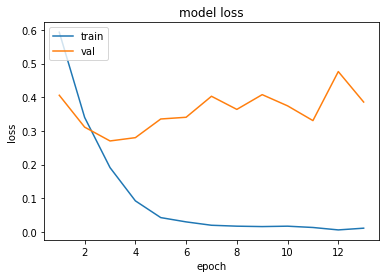

In [27]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

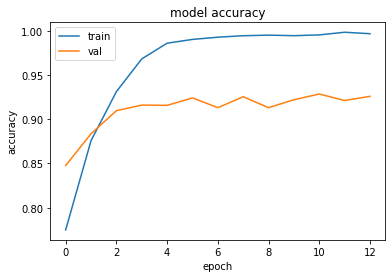

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [29]:
results = model.evaluate(test_X, test_y, batch_size=1024)
print("test loss, test acc: ", results)

8/8 [==============================] - 18s 1s/step - loss: 0.3905 - accuracy: 0.9224
test loss, test acc:  [0.39052724838256836, 0.9223880767822266]
